## Classification

### Binary Classification

Let's generate a toy dataset, visualize the set, and build a learning model to perform binary classification.

In [205]:
import torch
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [206]:
# make 1000 samples
n_samples = 1000

# create 1000 features and labels
X, y = make_circles(n_samples, noise=0.03, random_state=1234)

len(X), len(y)

(1000, 1000)

In [207]:
# first 5 samples of X
X[:5], y[:5]

(array([[-0.52776626,  0.61212075],
        [ 0.75325126, -0.10500465],
        [-0.34512841,  0.95759316],
        [-0.75567598, -0.14225749],
        [ 0.71738332, -0.69397855]]),
 array([1, 1, 0, 1, 0]))

In [208]:
# create a pandas dataframe
circles = pd.DataFrame({"X1": X[: ,0], "X2": X[: ,1], "label": y})

# display the first ten rows in the dataframe
circles.head(10)

,X1,X2,label
0,-0.527766,0.612121,1
1,0.753251,-0.105005,1
2,-0.345128,0.957593,0
3,-0.755676,-0.142257,1
4,0.717383,-0.693979,0
5,-0.119208,-0.987418,0
6,-0.523598,0.578420,1
7,0.601038,0.505682,1
8,0.008148,0.753410,1
9,0.261648,0.949329,0


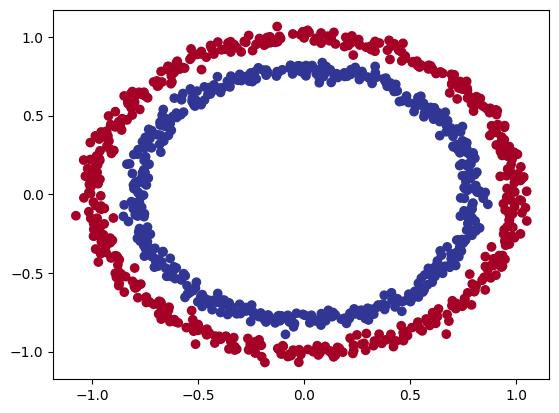

In [209]:
plt.scatter(x=X[: ,0], y=X[: ,1], c=y, cmap=plt.cm.RdYlBu)

In [210]:
type(X)

numpy.ndarray

In [211]:
# turn data into torch tensors (not float64, or we might get errors later)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [212]:
type(X)

torch.Tensor

In [213]:
# partition data into training-test subsets with the help of sklearn
training_features, test_features, training_labels, test_labels = train_test_split(X, y, test_size=0.2)

In [214]:
# check our random partitioning
training_features.shape, test_features.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

In [215]:
# autodetect GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [216]:
# construct a class with `nn.Module` as a subclass
class CircleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Add two nn.Linear layers
        # upscales input 2 to output 8, out_features must match in_features in stacked layers
        self.layer_1 = torch.nn.Linear(in_features=2, out_features=8)
        # out_feature here is our desired output (remember binary classification rules)
        self.layer_2 = torch.nn.Linear(in_features=8, out_features=1)
        
    # our forward pass method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [217]:
model_0 = CircleModel().to(device)

In [218]:
# replicate the above model with `nn.Sequential`
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=8),
    torch.nn.Linear(in_features=8, out_features=1)
)

# when we have more complex operations, it's important to know how to build our own classes to leverage `nn.Module`

In [219]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0459,  0.0343],
                      [-0.2555,  0.3295],
                      [ 0.6661, -0.0968],
                      [ 0.4770,  0.5604],
                      [-0.6422, -0.0892],
                      [ 0.5608, -0.1873],
                      [-0.3413, -0.2027],
                      [-0.3344, -0.5100]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.5605, -0.1310, -0.0732, -0.4773, -0.6050,  0.1852,  0.1495, -0.1835],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.3029,  0.3039,  0.2382, -0.2967,  0.3330, -0.1909, -0.2761, -0.3230]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.0116], device='cuda:0'))])

In [220]:
# disable gradient tracking
with torch.inference_mode():    
    # make some predictions
    untrained_predictions = model_0(test_features.to(device))
    print(f"Length of Predictions: {len(untrained_predictions)}, Shape: {untrained_predictions.shape}")
    print(f"Length of Samples: {len(test_features)}, Shape: {test_features.shape}")

Length of Predictions: 200, Shape: torch.Size([200, 1])
Length of Samples: 200, Shape: torch.Size([200, 2])


In [236]:
# Binary Cross Entropy (BCE) loss function and optimizer
loss_sigmoid = torch.nn.Sigmoid()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

# calculate accuracy
def accuracyCheck(label_true, label_predicted):
    correct = torch.eq(label_true, label_predicted).sum().item()
    accuracy = (correct/len(label_predicted)) * 100
    return accuracy

# set a manual seed for CUDA device
torch.cuda.manual_seed(1234)

# set number of Epochs
epochs = 100

# put all data on device
training_features, training_labels = training_features.to(device), training_labels.to(device)
test_features, test_labels = test_features.to(device), test_labels.to(device)

In [243]:
# build training and evaluation loop
for epoch in range(epochs):
    # TRAINING
    model_0.train()
    
    # forward pass
    feature_prediction = model_0(training_features).squeeze()
    
    # calculate training loss
    loss = loss_fn(loss_sigmoid(feature_prediction), label_predictions)
    
    # optimizer zero-grad
    optimizer.zero_grad()
    
    # backprop loss
    loss.backward()
    
    # TESTING
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_prediction = torch.round(model_0(test_features.squeeze()))
        
        # calculate test loss
        test_loss = loss_fn(test_labels)
    
    # PRINTOUT
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss:{test_loss:.5f}")

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.